# How to engineer investment alpha factors

Investment alpha factor engineering is a technique used in machine learning to transform different types of data into predictive signals. These signals, known as alpha factors, are designed to capture the risks that drive market movements which are used to make informed investment decisions.

ATR is a commonly used indicator in technical analysis that measures market volatility. Quants often use computational or technical alphas like ATR for isolating risk exposures during portfolio rebalancing.

In [4]:
# Imports and set up

# We’ll use pandas for data manipulation, the OpenBB SDK for data, and TA-Lib for an easy way to compute ATR. To determine the performance of ATR as a factor, we’ll use the Spearman rank correlation. Matploblib and Seaborn are for plotting.

# First, import the libraries.

import pandas as pd

from openbb_terminal.sdk import openbb
from talib import ATR

from scipy.stats import spearmanr
import matplotlib.pyplot as plt

import seaborn as sns
# Next, grab the data and do some preprocessing.

data = openbb.stocks.screener.screener_data(
    preset_loaded="most_volatile"
)

universe = data[
    (data.Country == "USA") & (data.Price > 5)
]

stocks = []
for ticker in universe.Ticker.tolist():
    df = (
        openbb
        .stocks
        .load(
            ticker,
            start_date="2010-01-01",
            verbose=False)
        .drop("Close", axis=1)
    )
    df["ticker"] = ticker
    stocks.append(df)

prices = pd.concat(stocks)
prices.columns = ["open", "high", "low", "close", "volume", "dividends", "stock_split", "ticker"]
prices

,open,high,low,close,volume,dividends,stock_split,ticker
date,,,,,,,,
2023-07-20,19.500000,35.575001,17.32,29.799999,15892100,0.0,0.0,PSQH
2018-05-08,320.000000,320.000000,320.00,320.000000,0,0.0,0.0,EVLO
2018-05-09,320.000000,328.600006,315.00,325.000000,101010,0.0,0.0,EVLO
2018-05-10,321.399994,326.000000,320.00,323.000000,9640,0.0,0.0,EVLO
2018-05-11,320.799988,322.000000,320.00,320.000000,3410,0.0,0.0,EVLO
...,...,...,...,...,...,...,...,...
2023-07-14,7.310000,7.480000,6.95,7.360000,81800,0.0,0.0,RPHM
2023-07-17,7.470000,7.654000,7.31,7.420000,83200,0.0,0.0,RPHM
2023-07-18,7.400000,7.610000,6.73,6.800000,92400,0.0,0.0,RPHM


In [5]:
# The OpenBB SDK has an awesome screener function that downloads a DataFrame of stocks based on pre-built screeners. In this case, I used the “most volatile” screener.

# Next, filter the stocks to reduce the universe size. I used country and price.

# Then, loop through each ticker and download price data starting in 2010. Add the ticker symbol as a column (you’ll see why in a minute) the concatenate the downloaded data together.

# From there, there are two more steps.

nobs = prices.groupby("ticker").size()
mask = nobs[nobs > 2 * 12 * 21].index
prices = prices[prices.ticker.isin(mask)]

prices = (
    prices
    .set_index("ticker", append=True)
    .reorder_levels(["ticker", "date"])
).drop_duplicates()

In [6]:
# Create the factor

# Create a simple function that computes the ATR.

def atr(data):
    df = ATR(data.high, data.low, data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

prices["atr"] = (
    prices
    .groupby("ticker", group_keys=False)
    .apply(atr)
)

In [7]:
# Assessing factor performance

# Alpha factors should be good at predicting future performance. The way to test this assumption is to find the Spearman rank correlation between the factor and future returns.

lags = [1, 5, 10, 21, 42, 63]
for lag in lags:
    prices[f"return_{lag}d"] = (
        prices.groupby(level="ticker")
        .close.pct_change(lag)
    )
# The first step creates 1, 5, 10, 21, 42, and 63 day lagged returns. This is helpful to understand the IC decay of the factor over time.

# Now generate the forward returns.

for t in [1, 5, 10, 21]:
    prices[f"target_{t}d"] = (
        prices
        .groupby(level="ticker")[f"return_{t}d"]
        .shift(-t)
    )
# The code creates 1, 5, 10, and 21 day forward returns based on each of the lags.

-1.69% (0.00%)


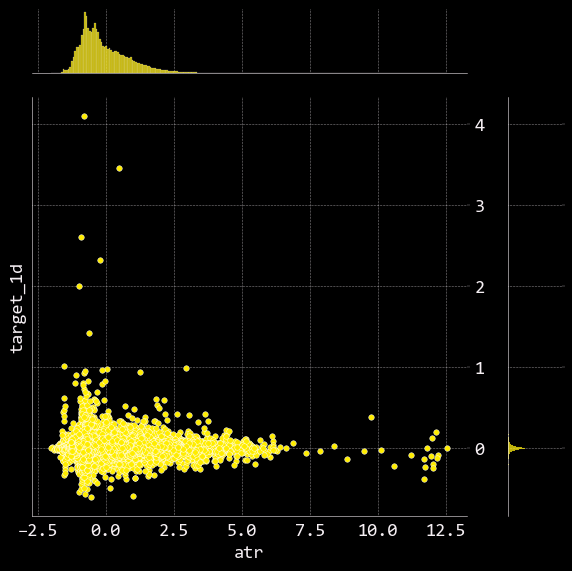

In [8]:
# Now, generate the results.

target = "target_1d"
metric = "atr"
j = sns.jointplot(x=metric, y=target, data=prices)
plt.tight_layout()

df = prices[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f"{r:,.2%} ({p:.2%})")

The scatter plot represents the forward return against the ATR z-score. We can see that most of the returns cluster near zero despite positive skew in the distribution of ATR metrics.

The code also prints out the Spearman rank correlation and p-score. The correlation is negative which makes sense: the higher the volatility, the lower the returns.